# Training baseline model

This notebook shows the implementation of a baseline model for our movie genre classification problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

Load the data and keep the title information: we will add the title to the overview, and delete the title column. 

In [2]:
path = '../data/movies_data_ready.csv'
df = pd.read_csv(path)
df['genres'] = df['genres'].apply(lambda x: x.split(','))
df['overview'] = df['title'].apply(lambda x: x.lower()).astype(str) + ' ' + df['overview']
del df['title']
df.head()

,overview,genres
0,toy story led woody andys toys live happily ro...,"[Animation, Comedy, Family]"
1,jumanji siblings judy peter discover enchanted...,"[Adventure, Fantasy, Family]"
2,grumpier old men family wedding reignites anci...,"[Romance, Comedy]"
3,waiting to exhale cheated mistreated stepped w...,"[Comedy, Drama, Romance]"
4,father of the bride part ii george banks recov...,[Comedy]


### One-hot vector representation and TF-IDF:

In [3]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])

# transform target variable
y = multilabel_binarizer.transform(df['genres'])
print(multilabel_binarizer.classes_)
print('size = ', len(multilabel_binarizer.classes_))

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']
size =  20


In [4]:
# Split the data in train, validate, test
testing_size = 0.15
x_train, x_test, y_train, y_test = train_test_split(df['overview'], y, test_size=testing_size, random_state=42)
validation_size_relative = testing_size/(1-testing_size)

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100000)
# create TF-IDF features
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train.values.astype('U'))
x_test_tfidf = tfidf_vectorizer.transform(x_test.values.astype('U'))

### ML model : Logistic regression

In [6]:
lr = LogisticRegression(solver='saga', n_jobs=-1, max_iter=1000)
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(x_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [7]:
# predict probabilities
y_pred_prob = clf.predict_proba(x_test_tfidf)

t = 0.5 # threshold value
y_pred_new = np.where(y_pred_prob >= t, 1, 0)

precision_recall_fscore_support(y_test, y_pred_new, average='micro')

(0.7443903969872901, 0.35158971318461424, 0.47759991946038455, None)

### ML model: SVC

In [8]:
svc = LinearSVC()
clf_svm = OneVsRestClassifier(svc)

# fit model on train data
clf_svm.fit(x_train_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [9]:
# make predictions for validation set
y_pred = clf_svm.predict(x_test_tfidf)

precision_recall_fscore_support(y_test, y_pred, average='micro')

(0.6675338753387534, 0.4563847921144297, 0.5421251870763272, None)

## ROC curves

In [10]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from matplotlib import colors as mcolors
import seaborn as sns

In [11]:
def plot_multilabel_ROC(classes_lab, y_score, title, hide_classes=False):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    n_classes = len(classes_lab)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds['micro'] = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw = 3
    
    # Plot all ROC curves
    plt.figure(figsize=(12,12))
    if not hide_classes:
        colors = cycle(sns.color_palette('bright', 8))
        for i, color in zip(range(n_classes), colors):
            lab = classes_lab[i] + '(auc = '+ str(round(roc_auc[i],2)) + ')'
            plt.plot(fpr[i], tpr[i], color=color, label=lab, linewidth=1)

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=8)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=8)   

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    return thresholds['micro'], fpr['macro'], tpr['macro']

In [12]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

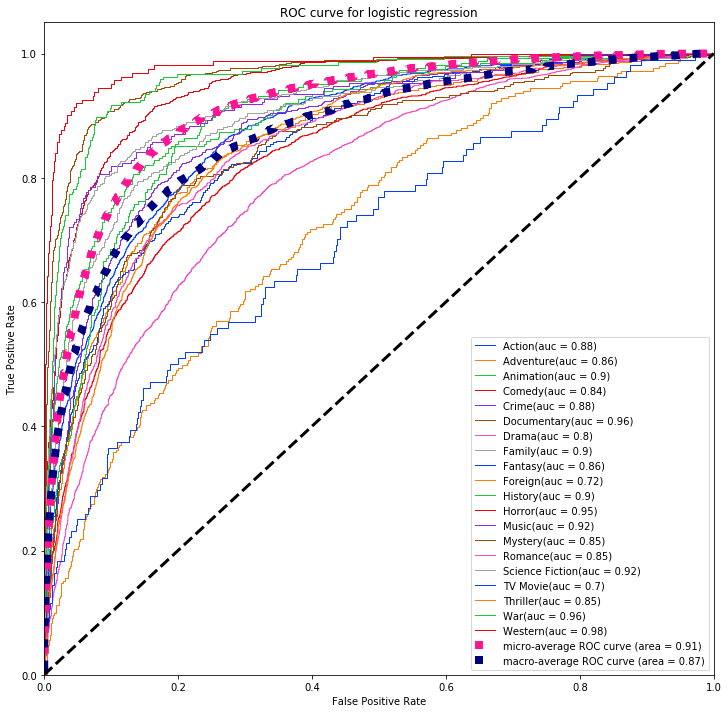

In [13]:
title = 'ROC curve for logistic regression'
thresh, fpr, tpr = plot_multilabel_ROC(multilabel_binarizer.classes_, y_pred_prob, title, hide_classes=False)

### Find the best threshold for logistic regression

In [14]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresh[optimal_idx]
optimal_threshold

0.36174461530123675

In [15]:
y_pred_new = np.where(y_pred_prob > optimal_threshold, 1, 0)

precision_recall_fscore_support(y_test, y_pred_new, average='micro')

(0.6529508355066165, 0.5010005187875195, 0.5669713998154827, None)

### Precision recall curve

In [16]:
from sklearn.metrics import precision_recall_curve

# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
step = 0.01
prec = {'micro':{}}
recall = {'micro':{}}
f1 = {'micro':{}}
thresholds = np.arange(0.0, 1.0, step)
for t in thresholds:
    pred_t = np.where(y_pred_prob >= t, 1, 0)
    prec['micro'][t], recall['micro'][t], f1['micro'][t], _ = precision_recall_fscore_support(y_test, pred_t, average='micro')

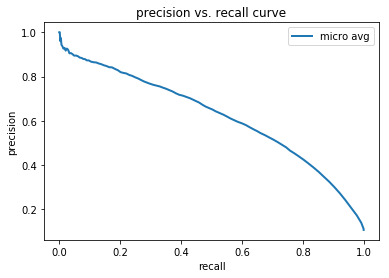

In [17]:
plt.plot(list(recall['micro'].values()), list(prec['micro'].values()), lw=2, label='micro avg')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [18]:
optimal_idx_micro = np.argmax(list(f1['micro'].values()))
print('micro optimal threshold:', thresholds[optimal_idx_micro])
y_pred_new = np.where(y_pred_prob > thresholds[optimal_idx_micro], 1, 0)
print(precision_recall_fscore_support(y_test, y_pred_new, average='micro'))

micro optimal threshold: 0.24
(0.5533123028391167, 0.6499666493737494, 0.5977575571686604, None)
